In [1]:
import numpy as np
import math
import skimage.transform
from keras.layers import Activation, Reshape, Dropout, Dense,Flatten
from keras.models import Sequential
from keras.layers import AtrousConvolution2D, Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils import plot_model
import keras.preprocessing.image as kimage
import keras.backend
import skimage
import colors
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import pickle, gzip
from utils import *
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report


Using TensorFlow backend.
/Users/niquo/anaconda/envs/tfDemo/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## INRODUCTION

In this pset we will construct the dilatedNet convolutional network (https://arxiv.org/pdf/1511.07122.pdf) for scene segmentation. This networks is an adaptation of the VGG-16 network. This prototxt file gives a description of the network on the authors github (https://github.com/fyu/dilation/blob/master/models/dilation8_pascal_voc_deploy.prototxt)
The classification challenge is to map each pixel in the image to a class of 151 objects as given in the ADE20k dataset.

![dilatedNet](model.png)

## PART A: MNIST

Before we get to constuct CNNs, let's first look at why they are useful.
As discussed in lecture CNNs are prefered over fully connected networks. To motivate why, let's first look at how the classic perceptron performs on the MNIST dataset. 
In mnist, the input images are digits and the classification problem is to identify the digit in the image. Let's load the training set and validation set from the mnist dataset.


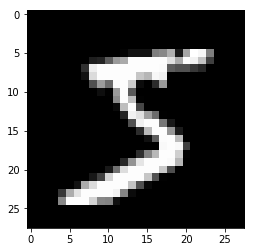

In [19]:
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f ,encoding='latin1')
f.close()

#display sample image from the trainset
image0 = train_set[0][0]
image0 = image0.reshape((28, 28))
showImg(image0)

We have the image of a 5 above. Let's see how a classic perceptron would perform in classifying images from the mnist database.

In [7]:
clf = Perceptron()
clf.fit(train_set[0], train_set[1])
pred_v = clf.predict(valid_set[0])
print(classification_report(valid_set[1], pred_v))

Our perceptron gives a precesion of 0.88 on the validation set. Let's see how a fully connected network would perform on the same problem. We will constuct a very simple fully connected network using keras. have a look a https://keras.io to see the API. We stack fully connected layers that are activated by the ReLU function. A softmax layer is added to give the output as a multiclass distribution over the classes. We will visit softmax later on in the pset.

The labels in the training set are integers. For the 5 we saw above the label would 5. We need to conver these labels to vectors that the network expects as its output. These are one hot vectors. E.g for 5, the corresponding vector would be [0,0,0,0,0,1,0,0,0,0] for 1 it would be [0,1,0,0,0,0,0,0,0] There are 10 classes (one for each digit). Implement transform_digits_to_one_hot below, it is a function that takes in an array of digits and converts them to an array of one hot vectors.

In [27]:
def transform_digits_to_one_hot(digits):
    raise NotImplementedError()

In [3]:
train_set_label = transform_digits_to_one_hot(train_set[1])
valid_set_label = transform_digits_to_one_hot(valid_set[1])

# contruct the fully connected model
model = Sequential()
model.add(Dense(units=256, input_dim=784))
model.add(Activation('relu'))
model.add(Dense(units=128))
model.add(Activation('relu'))
model.add(Dense(units=56))
model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('softmax'))

# set the loss function and use the sgd optimizer. print out accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# train the model
model.fit(train_set[0], train_set_label,epochs=10, batch_size=32)

# evaluate the model
result = model.evaluate(valid_set[0], valid_set_label, batch_size=128)
print("\n Loss on valid set:"  + str(result[0]) + " Accuracy on valid set: " + str(result[1]))

Our FCNN gives an Accuracy of 0.9613 on the mnist set. This is a lot better than the perceptron. Let use examine this model further. Keras has the model.summary() function to display information about the network.

In [2]:
print(model.summary())

The total number of parameters is 241,650. for each layer the number of parameters = #inputs x #units +  #biases. For the first layer we have (28 x 28) inputs x 256 weights for the units + 256 biases for the units, giving a total of 200960. As this is the most densly connected, this where most of the parameter lie. The second layer has 256 inputs and 128 weights at each unit and 128 biases giving a total of 256 x 128 + 128 = 32896 parameters. The densly connected layers have a lot of parameters. Lets see how a convolutional network performs. Below we use keras to implement a simple convolutional network. We will train it and see how it performs on the same dataset.

Note: The code below takes close to 10 minutes to train.

In [4]:
model = Sequential()
model.add(Convolution2D(filters=64,kernel_size=(3, 3), input_shape=(28, 28,1), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Convolution2D(kernel_size = (3,3), filters = 64,padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(units=128))
model.add(Dropout(rate= 0.5))
model.add(Dense(units=10))
model.add(Activation('softmax'))

print(model.summary())

# c
model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['accuracy'])

# because the convolution is on 2d images we will need to reshape the input to 28,28,1 images
train = np.reshape(train_set[0], (train_set[0].shape[0], 28, 28,1))
valid = np.reshape(valid_set[0], (valid_set[0].shape[0], 28, 28,1))

model.fit(train, train_set_label,epochs=10, batch_size=32)
print("Loss on valid set:"  + str(result[0]) + " Accuracy on valid set: " + str(result[1]))

The convolutional network has an accuracy of 0.9613 which is about the same as the fully connected network but only uses 111,882 parameters. In huge networks with huge inputs this difference makes a significant improvement on training performance.

## PART B: Convolutions And Segmentation

Before we get to implementing the network, lets look at how the convolution, pooling and softmax operations work.

The convolution operation applies a kernel patch of size $k \cdot k$ on an $n \cdot n$ matrix representing the image. The $k \cdot k$ patch is the sliding window that is moved by a stride S. Implement convolution below as a function that takes in the $n \cdot n$ image as a numpy array, the kernal size k and stride S and returns the convolved out put as a 2d array. Assume that both the image and kernel are squares. 
![_auto_0](attachment:_auto_0) 

![convolution; courtesy of https://cs231n.github.io/assets/conv-demo/index.html]( convolution.png)

In equation form the discrete 2d convolution given Kernel K of size k and image I can be described as:

$ O[i,j] = \sum_{u=-\frac{k}{2}}^{u=\frac{k}{2}}\sum_{v=-\frac{k}{2}}^{v=\frac{k}{2}} K[u][v] \cdot I[i-u][v-j] $

Note that the kernel is flipped before performing the dot operation.

The output dimensions of the convolution are expressed as follows:

$d = \frac{W-F+2P}{S} + 1 $ 

Where d is the output width, W is the Image width, F is the filter width and S is the stride. P is the padding. Padding with 0s is applied when the kernel patches can't 'fit'. For this problem we will ignore padding. That means P=0. The provided kernal,image and stride will always give an integer output dimension (d) so do not wory about cases where the kernel doesn't fit. 



In [9]:
def convolution(image, K, S):
    raise NotImplementedError()

Convolution is an important operation on images and in signal processing. It can be used to implement many image processing filter as seen lecture. one application is to implement the sobel filter for image edge detection https://en.wikipedia.org/wiki/Sobel_operator
This simply the convolution of an image with the kernel.

The sobel filter uses two kernals kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) and ky = np.array([[1,2,1],[0,0,0],[0,0,0]]). The resulting image is the sum of the two.

implement the sobel filter below. You are given the image as 2d array, you need to return a 2d array as the result of the convolution. Since we are not using padding, the output from your convolution may be a different size from the original image.

Use the function showImg() to display your image.

In [ ]:
def sobel(image):
    # your code here
    raise NotImplementedError()

The max pooling operation takes in an image of size n*n and a poolsize of p. It applies a p*p patch with stride S on the image and for each patch outputs the max value in that patch. The output is an (n/p)*(n/p) 2d image. for simplicity, we will assume p is a multiple of n to avoid worrying about edges.

In [3]:
def max_pool(image,pool_size,Stride):
    # your code here
    raise NotImplementedError()

Each layer needs and an activation function. As descibed in lecture, the ReLU function is commonly used in practice. This is simply descibed as max(0,x) where x is in input. Implement ReLU below.

In [4]:
def ReLU(x):
    # your code here
    raise NotImplementedError()

In this network, we have a multiclass classification problem. Our output from the convolutions is a 'score' for each class for each pixel. e.g Say we have classification maping where 0 is cat , 1 is dog , 2 is boy. if we get an output as [1,16,3] from our convolution, it means our network believes this pixel is likely to belong to dog and assigns it a score of 16. To represent this as propablity distribution, we use the softmax operation and apply it to the ouput of our final layer. The can be used to represent the categorical distribution for that pixel assignment. The softmax operation is defined below

$\sigma(x)_{j} = \cfrac{e^{x_{j}}}{\sum_{i=1}^{i=k}e^{x_{k}}} $

Implement the softmax function that takes in a 1d array and returns an array represting the softmax distribution. Here the number of classes is the same as the size of the array.

In [5]:
def sofmax(arr):
    # your code here
    raise NotImplementedError()

Now that we have the core functions implemented we are ready to build the network. We will use the keras api to build the network. see https://keras.io/
The dilatedNet layers and their names are descibed in this file (https://github.com/fyu/dilation/blob/master/models/dilation8_pascal_voc_deploy.prototxt). For the tester to check your work, remember to use the same names for your layers. (e.g by passing name='conv1_1') as a parameter to the Convolution2D function.
In particular, we will use the Convolution2D, MaxPooling2D and Activation('softmax'),Reshape methods for the network. Each pixel is maped to 151 possible classes so the output is size 151 * output_width * output_height. Implement the get model function below. We have implemented the first layer for you. Add the rest of the layers and remember to reshape and apply softmax at the end. You may want to pass in padding='same' incase where you want to use padding on the convolutions to save the spatial dimensions.

In [6]:
def get_model(input_width, input_height):
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv1_1', input_shape=(3,input_width, input_height), padding='same'))
    
    # your code here
    #use model.add to add your layers
    
    raise NotImplementedError()
    #print(model.summary) # shows a desciption of the model and its parameters
    return model

Now that we have the model, we need to set up the training inputs and outputs. The trainingset for ADE20k is an input of images in RGB and a label of Images in grayscale where the grayscale value of each pixel indicates the class it belongs to.

RGB images have 3 channels. Write the function img_to_array that takes in an image url and return a 3d array where the first dimension is the height, the second dimension is the witdth last is the channel.

In [7]:
def img_to_array(width, height, url="https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/images/ADE_val_00000003.jpg?raw=true"):
    f.open('temp_im.jpg','wb')
    f.write(urllib.request.urlopen(url).read())
    im = Image.open('temp.jpg')
    im = im.crop((0,0,width,height))
    im.show()
    
    #change the im to an array. look at the pillow documentation for an example
    raise NotImplementedError()
    
    
    

Our labels are images in grayscale (1 channel) where the grayscale value represents the class. Those images need to be converted to a 2d array of size (width*height,151), where the fist dimension is the pixel and the second dimension is a 151 length one hot vector represnting the class of the pixel. Implement the label_image_to_one_hot function below.

In [8]:
def label_image_to_one_hot(width, height, url="https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/annotations/ADE_val_00000003.png?raw=true"):
    f.open('temp_label.jpg','wb')
    f.write(urllib.request.urlopen(url).read())
    im = Image.open('temp_label.jpg')
    im = im.crop((0,0,width,height))
    im.show()
    
    #Your code here
    
    raise NotImplementedError()

After applying softmax on the last layer, the output is a 2d vector of size (output_width * output_height, 151). 

Again the first dimentions is the pixel and the second dimention is an array this the probability distribution of the pixel belonging to the classes. To display this as an image, we can simply choose the class with highes value and output that as the grayscale value in the image and then reshape the along the first dimension to get back a 2d grayscale image. Implement the softmax_output_to_image function below. this function takes in a 2d array of shape (output_width * output_height, 151) and outputs a grayscale 2d array of shape (output_width , output_height,1). The 1 is for the number of channels.
for simplicity we will assume the output_width=output_height

In [9]:
def softmax_output_to_image(arr):
    w = np.sqrt(arr.shape[0])
    img_arr = np.array((w,w,1 ))
    
    #your code here
    #fill in img_arr with your image data
    
    raise NotImplementedError()
    im = Image.fromarray(np.uint8(img_arr))
    im.show()
    return img_arr
    


To train the network, we would pass in images, and labels to to the model. Next, we would specify the loss function to that back propagation would use to train the network and an optimization algorithm. In the case of segmentation we will use the categorical_crossentropy loss function to give a loss value for the multiclass classification predictions.There are a variety of optimizer available. Because the loss function are highly dimenstional have mant local minima, we need an optimzers that use gradient descent and possible stochastic methods to find a global minimum. A popular otimizer is the adam optimizer. 
In keras, training would look like this:

In [11]:
def train():
    # we will train on three images
    img1 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/images/ADE_val_00000001.jpg?raw=true"
    label1 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/annotations/ADE_val_00000001.png?raw=true"

    img2 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/images/ADE_val_00000002.jpg?raw=true"
    label2 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/annotations/ADE_val_00000002.png?raw=true"
    
    img3 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/images/ADE_val_00000003.jpg?raw=true"
    label3 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/annotations/ADE_val_00000003.png?raw=true"

    
    # lets use 384 *384 size images
    width, height = 384,384
    model = get_model(width, height)
    print(model.summary())
    
    nbclasses = 151
    print("images")
    X_train = np.array( [img_to_array(width, height,img1), img_to_array(width, height,img2),
                         img_to_array(width, height,img3)] )
    print("labels")
    
    _,size,_   = model.layers[-1].output_shape
    print(size)
    width, height = (int(np.sqrt(size)),)*2
    
    Y_train = np.array( [label_image_to_one_hot(width, height,nbclasses, label1),
                         label_image_to_one_hot(width, height,nbclasses,label2), 
                         label_image_to_one_hot(width, height,nbclasses, label3)] )
    
    
    
    # set the optimizer and loss function. metrics is a list of metrics we would like to observe. 
    # They do not affect the training process but let us see how well we are doing 
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    # train the model
    # epochs is the number of times we would like to visit each image
    model.fit(X_train, Y_train, 
          batch_size=3, epochs=1, verbose=1)
    


As you can tell, training takes a while. To save you the effort, we have already trained this model and saved the weights. Let now load the weights and run a prediction on an image.

In [12]:
def load_weights(model):
    #download from https://www.dropbox.com/s/9gnt784tu1m269n/dilatednet.npy?dl=0
    weights_data = np.load('./dilatednet.npy', encoding='latin1').item()
    for layer in model.layers:
        if layer.name in weights_data.keys():
            layer_weights = weights_data[layer.name]
            if 'biases' in layer_weights:
                layer.set_weights((layer_weights['weights'],
                                   layer_weights['biases']))

In [50]:
def predict():
    width, height = 384,384
    model = get_model(width, height)
    print(model.summary())
    
    # feel free to try other images
    #img1 = "https://github.com/CSAILVision/sceneparsing/blob/master/sampleData/images/ADE_val_00000003.jpg?raw=true"

    #img1 = "http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/training/a/art_school/ADE_train_00001703.jpg"

    #img1 = "http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/training/a/art_school/ADE_train_00001705.jpg"

    #img1 = "http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/validation/p/playground/ADE_val_00000707.jpg"

    #img1 =  "http://groups.csail.mit.edu/vision/datasets/ADE20K//ADE20K_2016_07_26/images/validation/p/podium/indoor/ADE_val_00001711.jpg"

    img1 = "https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png"
    
    print("prediction image")
    
    #preprocess based on training data
    a = img_to_array(width, height,img1)
    mean = [109.5388, 118.6897, 124.6901]; # mean RGB values from training set
    a = a[:,:,::-1] - mean #convert to BGR to match training
    
    X = np.array( [a])
    
    load_weights(model)
    Y = model.predict(X)
    
    print("prediction output",Y.shape)
    width = int(np.sqrt(Y[0].shape[0]))
    
    #get the image from softmax
    im = softmax_output_to_image(Y[0])

    #color and upsample the image
    ca = colorEncode(im.reshape((width,width,1)))
    ca = skimage.transform.rescale(ca, 8, mode='constant', cval=0)
    im = keras.preprocessing.image.array_to_img(ca)
    #im.show()
    plt.imshow(ca)
    plt.show()


def colorEncode(grayArr):
    out = colors.colors[grayArr.ravel()].reshape(
        grayArr.shape[0:2] + (3,))
    return out


How can the CNN be improved? TODO: better phrasing. More creative questions.

Training of CNNs is an intensive task. To improve learning from a dataset we can preprocess the image to improve performance or expand the training set. List some operations that you think would be good preprocessing steps.

Your Answer Here

CNN units have the locality and shared weights properties. What makes these particularly useful in image classification problems?

In [ ]:
Your Answer Here

CNNs have proven superior in image/video type classification problems. Can you give an example of a type of problem where you would expect CNNs to perform poorly.

Your Answer Here

Thanks for playing